<a href="https://colab.research.google.com/github/rht6226/DL/blob/main/Model_Training_on_Opportunity_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Preprocessed Data

In [150]:
import numpy as np
from keras.utils import to_categorical
import json
import matplotlib

In [151]:
class OpportunityDataset:
    def __init__(self, filepath):
        with np.load(filepath + 'training.npz') as data:
            self.trainX = data['X']
            self.trainy = to_categorical(data['y'])
            
        with np.load(filepath + 'testing.npz') as data:
            self.testX = data['X']
            self.testy = to_categorical(data['y'])

        with open(filepath + 'classes.json') as classes:
            self.labels=json.load(classes)

    
    def summary(self):
        print("Opportunity Human Activity Recognition Dataset: ")
        print("Shape of training data = X:{}, y: {}".format(self.trainX.shape, self.trainy.shape))
        print("Shape of testing data = X:{}, y: {}".format(self.testX.shape, self.testy.shape))
        # print("Shape of validation data = X:{}, y: {}".format(self.validateX.shape, self.validatey.shape))
        print("Number of available labels for classification : {}".format(len(self.labels)))

In [152]:
opp = OpportunityDataset('/content/drive/My Drive/HAR Processed Data/Opportunity_Timesteps/')
opp.summary()

Opportunity Human Activity Recognition Dataset: 
Shape of training data = X:(58346, 24, 113), y: (58346, 18)
Shape of testing data = X:(14100, 24, 113), y: (14100, 18)
Number of available labels for classification : 18


# Training on 1D CNN

## Model Training

In [137]:
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import MaxPooling1D, Conv1D, Flatten, Dense, Concatenate, GRU, Input, Dropout, concatenate
from keras.utils.vis_utils import plot_model

In [138]:
def get_1DCNN_model(trainX, trainy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    # Model Definitions
    model = Sequential()
    model.add(Conv1D(filters=339, kernel_size=3, padding='same', activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=226, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(filters=113, kernel_size=5, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    model.add(Dense(units=100, activation='relu', 
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4),
                    activity_regularizer=regularizers.l2(1e-5)
                    ))
    
    model.add(Dense(units=n_outputs, activation='softmax', 
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4),
                    activity_regularizer=regularizers.l2(1e-5)
                    ))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print stuff
    print(model.summary())
    return model

In [139]:
# Summarising the model Architecture

model_1D_CNN = get_1DCNN_model(opp.trainX, opp.trainy)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 24, 339)           115260    
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 24, 226)           230068    
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 24, 113)           127803    
_________________________________________________________________
dropout_21 (Dropout)         (None, 24, 113)           0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 12, 113)           0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1356)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)             

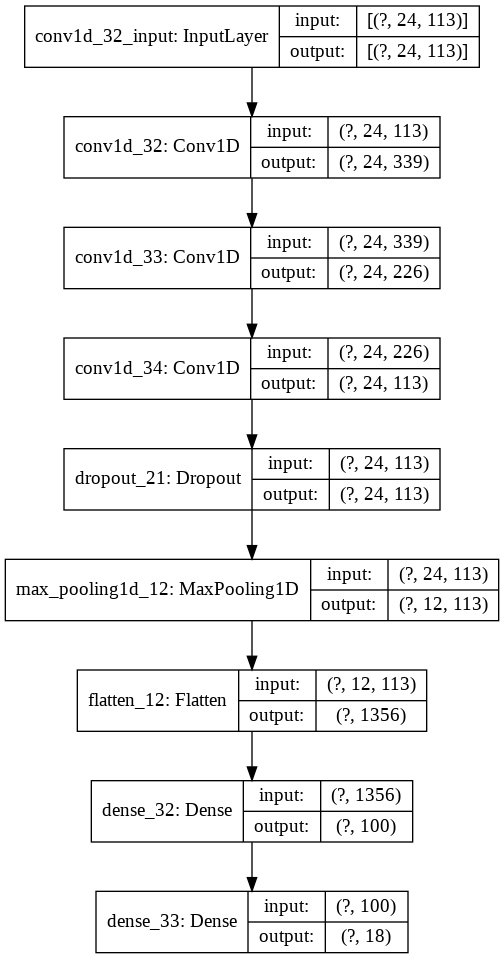

In [140]:
plot_model(model_1D_CNN, show_shapes=True, show_layer_names=True)

In [141]:
epochs, batch_size = 350, 64
history_1D_CNN_UCI = model_1D_CNN.fit(opp.trainX, opp.trainy, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(opp.testX, opp.testy))

Epoch 1/350
912/912 [==============================] - 6s 6ms/step - loss: 1.0032 - accuracy: 0.7380 - val_loss: 0.8995 - val_accuracy: 0.7621
Epoch 2/350
912/912 [==============================] - 5s 6ms/step - loss: 0.7460 - accuracy: 0.7710 - val_loss: 0.6783 - val_accuracy: 0.8117
Epoch 3/350
912/912 [==============================] - 5s 6ms/step - loss: 0.6616 - accuracy: 0.7882 - val_loss: 0.6562 - val_accuracy: 0.8135
Epoch 4/350
912/912 [==============================] - 5s 6ms/step - loss: 0.5995 - accuracy: 0.8041 - val_loss: 0.6696 - val_accuracy: 0.8190
Epoch 5/350
912/912 [==============================] - 5s 6ms/step - loss: 0.5506 - accuracy: 0.8186 - val_loss: 0.6884 - val_accuracy: 0.7836
Epoch 6/350
912/912 [==============================] - 5s 6ms/step - loss: 0.5208 - accuracy: 0.8279 - val_loss: 0.6190 - val_accuracy: 0.8280
Epoch 7/350
912/912 [==============================] - 5s 6ms/step - loss: 0.4906 - accuracy: 0.8389 - val_loss: 0.6091 - val_accuracy: 0.8301

In [153]:
model_1D_CNN.save('/content/drive/My Drive/Colab Notebooks/Models/1DCNN_OPPORTUNITY.h5')

In [154]:
_, accuracy = model_1D_CNN.evaluate(opp.testX, opp.testy, batch_size=batch_size, verbose=1)
print(accuracy)

221/221 [==============================] - 1s 4ms/step - loss: 0.8308 - accuracy: 0.8249
0.824893593788147


## Plotting Accuracy

In [155]:
# Plotting Loss and Accuracy

import matplotlib.pyplot as plt

def plot_model_accuracy(details, history, figureSize=[8, 8]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy for {}'.format(details))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_model_loss(details, history, figureSize=[8, 8]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss for {}'.format(details))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

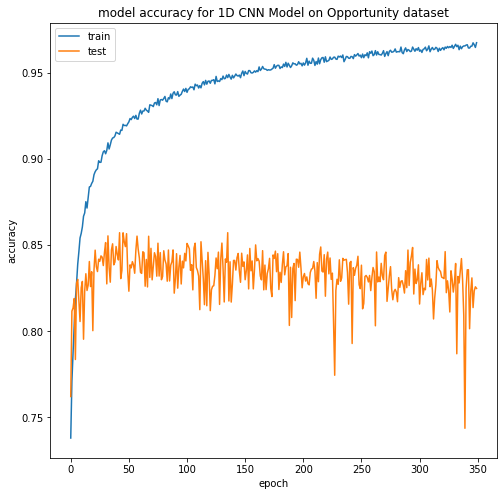

In [156]:
plot_model_accuracy("1D CNN Model on Opportunity dataset", history=history_1D_CNN_UCI)

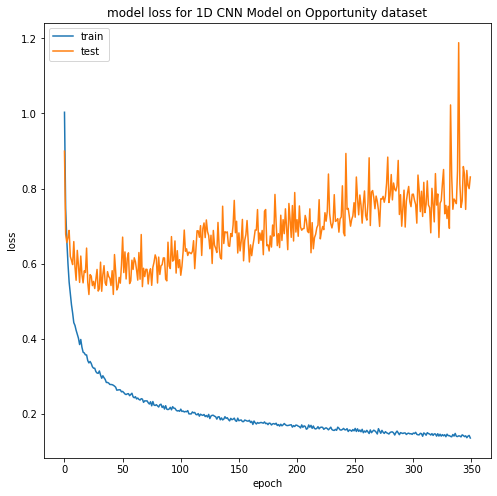

In [157]:
plot_model_loss("1D CNN Model on Opportunity dataset", history=history_1D_CNN_UCI)

## Plotting Confusion Matrix

In [158]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [159]:
def plot_cm(predictedY, testy, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, figureSize=[10, 10]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    # Predict Y, And get Confusion Matrix
    predictedY = np.argmax(predictedY, axis = 1)
    testy = np.argmax(testy, axis=1)
    cm = confusion_matrix(y_true=testy, y_pred=predictedY)

    # Plotting
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


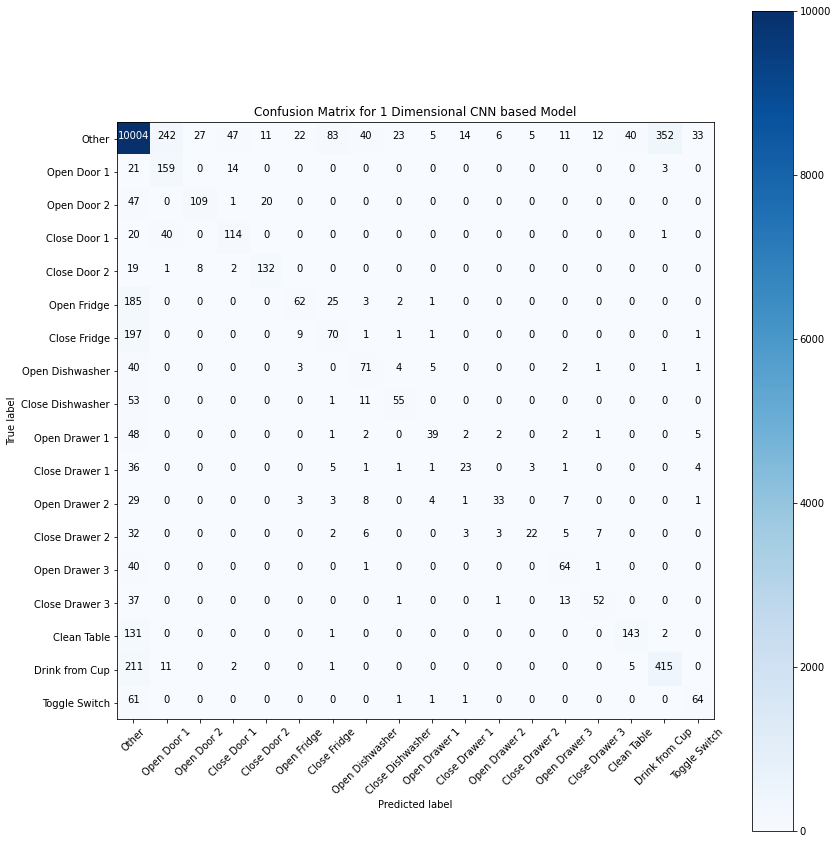

In [160]:
# CNN Based Network
predictedY = model_1D_CNN.predict(opp.testX)
cm_plot_labels = opp.labels
plot_cm(predictedY, testy=opp.testy, classes=cm_plot_labels, title='Confusion Matrix for 1 Dimensional CNN based Model', figureSize=[12, 12])

## Classification Report

In [161]:
from sklearn.metrics import classification_report

In [162]:
# 1D CNN based Model
predictedY = model_1D_CNN.predict(opp.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(opp.testy, axis=1)
target_names = opp.labels
print(classification_report(y_true, y_pred, target_names=target_names))

                  precision    recall  f1-score   support

           Other       0.89      0.91      0.90     10977
     Open Door 1       0.35      0.81      0.49       197
     Open Door 2       0.76      0.62      0.68       177
    Close Door 1       0.63      0.65      0.64       175
    Close Door 2       0.81      0.81      0.81       162
     Open Fridge       0.63      0.22      0.33       278
    Close Fridge       0.36      0.25      0.30       280
 Open Dishwasher       0.49      0.55      0.52       128
Close Dishwasher       0.62      0.46      0.53       120
   Open Drawer 1       0.68      0.38      0.49       102
  Close Drawer 1       0.52      0.31      0.39        75
   Open Drawer 2       0.73      0.37      0.49        89
  Close Drawer 2       0.73      0.28      0.40        80
   Open Drawer 3       0.61      0.60      0.61       106
  Close Drawer 3       0.70      0.50      0.58       104
     Clean Table       0.76      0.52      0.62       277
  Drink from 

## Overall accuracy using Weighted F-Beta Score

In [163]:
from sklearn.metrics import precision_recall_fscore_support as score

In [165]:
predictedY = model_1D_CNN.predict(opp.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(opp.testy, axis=1)

precision,recall,fscore, _ = score(y_true,y_pred,average='weighted')
print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F-score   : {}'.format(fscore))

Precision : 0.8267333923388622
Recall    : 0.8248936170212766
F-score   : 0.8198969647302311


# LSTM Based Model

## Model Training

In [166]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils.vis_utils import plot_model

In [167]:
input_shape, n_outputs = (opp.trainX.shape[1], opp.trainX.shape[2]) , opp.trainy.shape[1]

In [168]:
def get_lstm_model(input_shape, n_outputs):
    model = Sequential()
    model.add(LSTM(300, input_shape=input_shape))
    model.add(Dropout(0.5))

    model.add(Dense(units=100, activation='relu', 
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                    bias_regularizer=regularizers.l2(1e-4), 
                    activity_regularizer=regularizers.l2(1e-5)
                    ))
    
    model.add(Dense(n_outputs, activation='softmax',
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                    bias_regularizer=regularizers.l2(1e-4), 
                    activity_regularizer=regularizers.l2(1e-5)
                    ))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [169]:
model_lstm = get_lstm_model(input_shape=input_shape, n_outputs=n_outputs)
model_lstm.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 300)               496800    
_________________________________________________________________
dropout_22 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_35 (Dense)             (None, 18)                1818      
Total params: 528,718
Trainable params: 528,718
Non-trainable params: 0
_________________________________________________________________


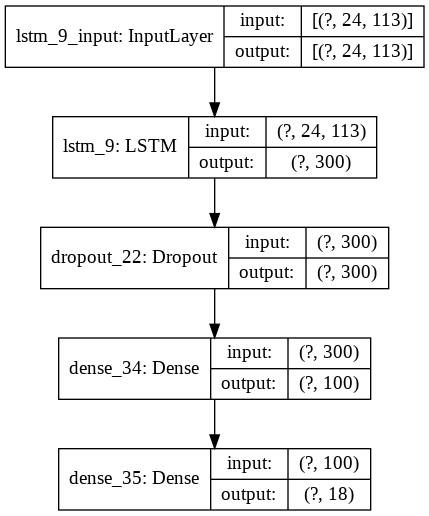

In [170]:
plot_model(model_lstm, show_shapes=True, show_layer_names=True)

In [171]:
verbose, epochs, batch_size = 1, 100, 64
history_lstm = model_lstm.fit(opp.trainX, opp.trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(opp.testX, opp.testy))

Epoch 1/100
912/912 [==============================] - 7s 8ms/step - loss: 1.1543 - accuracy: 0.7182 - val_loss: 1.0201 - val_accuracy: 0.7790
Epoch 2/100
912/912 [==============================] - 6s 7ms/step - loss: 0.8440 - accuracy: 0.7575 - val_loss: 0.9582 - val_accuracy: 0.7336
Epoch 3/100
912/912 [==============================] - 6s 7ms/step - loss: 0.7348 - accuracy: 0.7735 - val_loss: 0.6955 - val_accuracy: 0.8010
Epoch 4/100
912/912 [==============================] - 6s 7ms/step - loss: 0.6659 - accuracy: 0.7860 - val_loss: 0.6602 - val_accuracy: 0.8043
Epoch 5/100
912/912 [==============================] - 6s 7ms/step - loss: 0.6204 - accuracy: 0.7964 - val_loss: 0.6277 - val_accuracy: 0.8136
Epoch 6/100
912/912 [==============================] - 6s 7ms/step - loss: 0.5853 - accuracy: 0.8055 - val_loss: 0.6082 - val_accuracy: 0.8108
Epoch 7/100
912/912 [==============================] - 7s 7ms/step - loss: 0.5609 - accuracy: 0.8135 - val_loss: 0.6509 - val_accuracy: 0.8013

In [87]:
model_lstm.save('/content/drive/My Drive/Colab Notebooks/Models/LSTM_OPPORTUNITY.h5')

In [90]:
_, accuracy = model_lstm.evaluate(opp.testX, opp.testy, batch_size=64, verbose=1)
print("Accuracy for LSTM based model = {}".format(accuracy))

221/221 [==============================] - 1s 4ms/step - loss: 0.8260 - accuracy: 0.8301
Accuracy for LSTM based model = 0.8301418423652649


## Plotting Accuracy

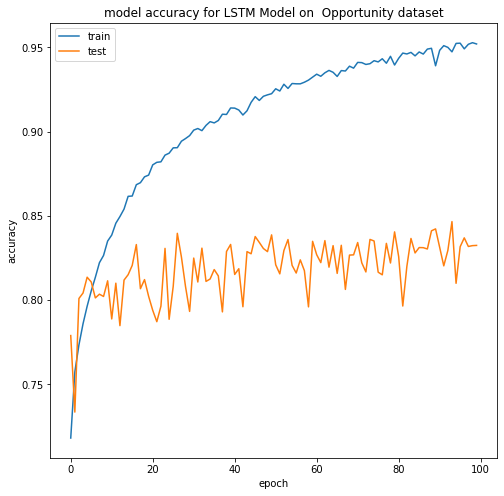

In [172]:
plot_model_accuracy("LSTM Model on  Opportunity dataset", history=history_lstm)

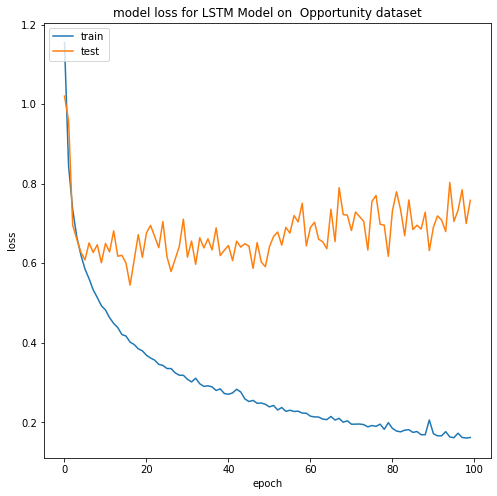

In [173]:
plot_model_loss("LSTM Model on  Opportunity dataset", history=history_lstm)

## Plotting Confusion Matrix

Confusion matrix, without normalization


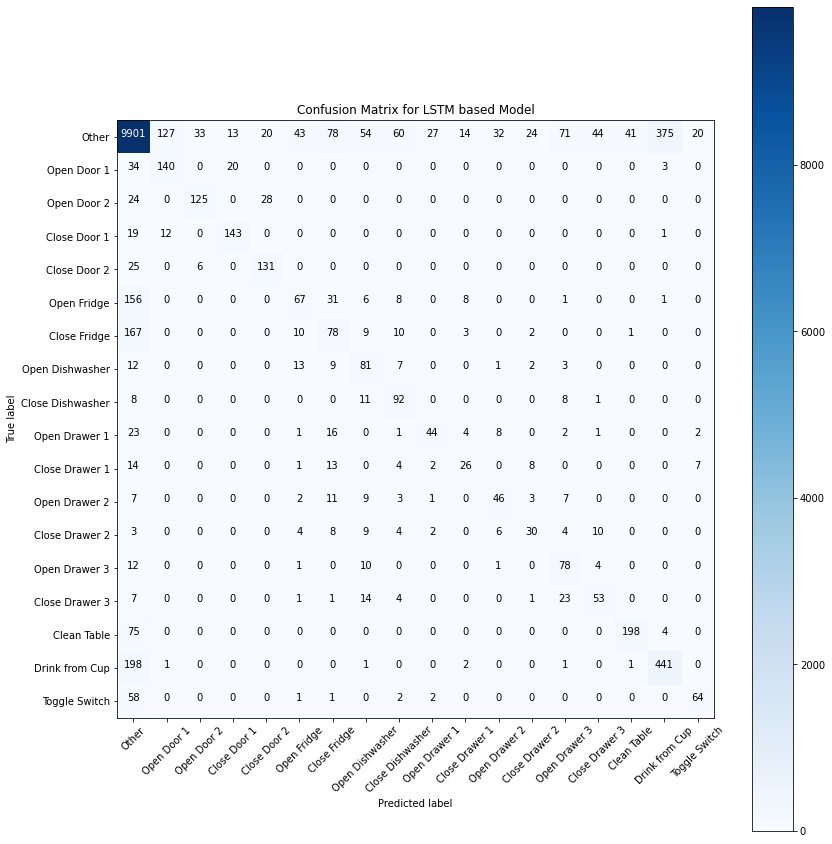

In [213]:
# CNN Based Network
predictedY = model_lstm.predict(opp.testX)
cm_plot_labels = opp.labels
plot_cm(predictedY, testy=opp.testy, classes=cm_plot_labels, title='Confusion Matrix for LSTM based Model', figureSize=[12, 12])

## Classification Report

In [214]:
# LSTM based Model
predictedY = model_lstm.predict(opp.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(opp.testy, axis=1)
target_names = opp.labels
print("LSTM Based Model:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

LSTM Based Model:

                  precision    recall  f1-score   support

           Other       0.92      0.90      0.91     10977
     Open Door 1       0.50      0.71      0.59       197
     Open Door 2       0.76      0.71      0.73       177
    Close Door 1       0.81      0.82      0.81       175
    Close Door 2       0.73      0.81      0.77       162
     Open Fridge       0.47      0.24      0.32       278
    Close Fridge       0.32      0.28      0.30       280
 Open Dishwasher       0.40      0.63      0.49       128
Close Dishwasher       0.47      0.77      0.58       120
   Open Drawer 1       0.56      0.43      0.49       102
  Close Drawer 1       0.46      0.35      0.39        75
   Open Drawer 2       0.49      0.52      0.50        89
  Close Drawer 2       0.43      0.38      0.40        80
   Open Drawer 3       0.39      0.74      0.51       106
  Close Drawer 3       0.47      0.51      0.49       104
     Clean Table       0.82      0.71      0.76     

## Overall accuracy Using Weighted F-Beta Score

In [215]:
predictedY = model_lstm.predict(opp.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(opp.testy, axis=1)

precision,recall,fscore, _ = score(y_true,y_pred,average='weighted')
print("LSTM Based Model:\n")
print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F-score   : {}'.format(fscore))

LSTM Based Model:

Precision : 0.8409184414910124
Recall    : 0.8324822695035461
F-score   : 0.8339186420503909


# CNN-LSTM Based Model

## Model Trainig

In [177]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.utils.vis_utils import plot_model

In [178]:
# Split the dataset from timesteps of 24 to 3 subsequences of size 8 each
n_steps, n_length = 2, 12
n_features, n_outputs = opp.trainX.shape[2] , opp.trainy.shape[1]
trainX = opp.trainX.reshape((opp.trainX.shape[0], n_steps, n_length, n_features))
testX = opp.testX.reshape((opp.testX.shape[0], n_steps, n_length, n_features))

In [202]:
def get_cnn_lstm_model(n_length, n_features, n_outputs):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=113, kernel_size=3, padding='same', activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=65, kernel_size=3, padding='same', activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, strides=1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(120))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [203]:
print("Reshaped the trainX data from {} to : {}".format(opp.trainX.shape, trainX.shape))
print("Reshaped the testX data from {} to : {}".format(opp.testX.shape, testX.shape))

Reshaped the trainX data from (58346, 24, 113) to : (58346, 2, 12, 113)
Reshaped the testX data from (14100, 24, 113) to : (14100, 2, 12, 113)


In [204]:
model_cnn_lstm = get_cnn_lstm_model(n_length, n_features, n_outputs)
model_cnn_lstm.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_50 (TimeDis (None, None, 12, 113)     38420     
_________________________________________________________________
time_distributed_51 (TimeDis (None, None, 12, 65)      22100     
_________________________________________________________________
time_distributed_52 (TimeDis (None, None, 12, 65)      0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, None, 11, 65)      0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, None, 715)         0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 120)               401280    
_________________________________________________________________
dropout_36 (Dropout)         (None, 120)             

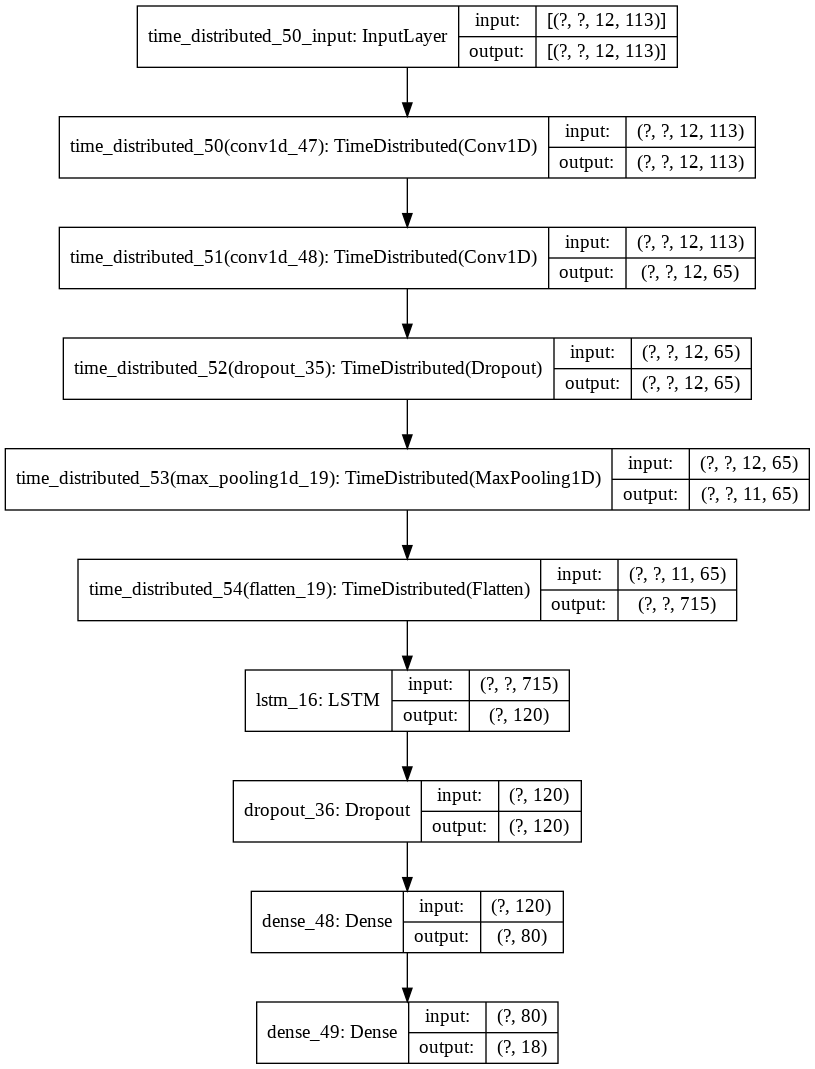

In [205]:
plot_model(model=model_cnn_lstm, show_layer_names=True, show_shapes=True)

In [206]:
verbose, epochs, batch_size = 1, 200, 64
history_cnn_lstm = model_cnn_lstm.fit(trainX, opp.trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(testX, opp.testy))

Epoch 1/200
912/912 [==============================] - 6s 6ms/step - loss: 1.0183 - accuracy: 0.7321 - val_loss: 0.7365 - val_accuracy: 0.8046
Epoch 2/200
912/912 [==============================] - 5s 6ms/step - loss: 0.7625 - accuracy: 0.7637 - val_loss: 0.8492 - val_accuracy: 0.7381
Epoch 3/200
912/912 [==============================] - 5s 6ms/step - loss: 0.6613 - accuracy: 0.7810 - val_loss: 0.6680 - val_accuracy: 0.7957
Epoch 4/200
912/912 [==============================] - 5s 6ms/step - loss: 0.6204 - accuracy: 0.7906 - val_loss: 0.6670 - val_accuracy: 0.7894
Epoch 5/200
912/912 [==============================] - 5s 6ms/step - loss: 0.5821 - accuracy: 0.8024 - val_loss: 0.6289 - val_accuracy: 0.7970
Epoch 6/200
912/912 [==============================] - 5s 6ms/step - loss: 0.5466 - accuracy: 0.8121 - val_loss: 0.5834 - val_accuracy: 0.8170
Epoch 7/200
912/912 [==============================] - 5s 6ms/step - loss: 0.5189 - accuracy: 0.8210 - val_loss: 0.5649 - val_accuracy: 0.8241

In [209]:
model_cnn_lstm.save('/content/drive/My Drive/Colab Notebooks/Models/CNN_LSTM_OPPORTUNITY.h5')

In [210]:
_, accuracy = model_cnn_lstm.evaluate(testX, opp.testy, batch_size=batch_size, verbose=1)
print(accuracy)

221/221 [==============================] - 1s 3ms/step - loss: 0.6607 - accuracy: 0.8463
0.8463120460510254


## Plotting Accuracy

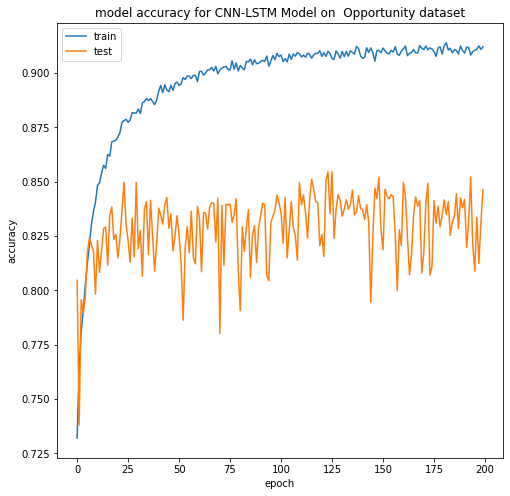

In [211]:
plot_model_accuracy("CNN-LSTM Model on  Opportunity dataset", history=history_cnn_lstm)

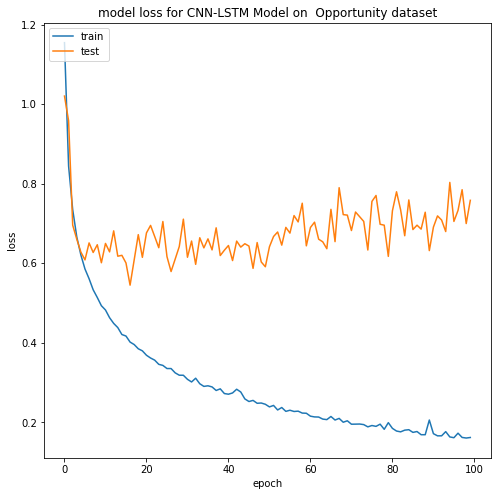

In [216]:
plot_model_loss("CNN-LSTM Model on  Opportunity dataset", history=history_lstm)

## Plotting Confusion Matrix

Confusion matrix, without normalization


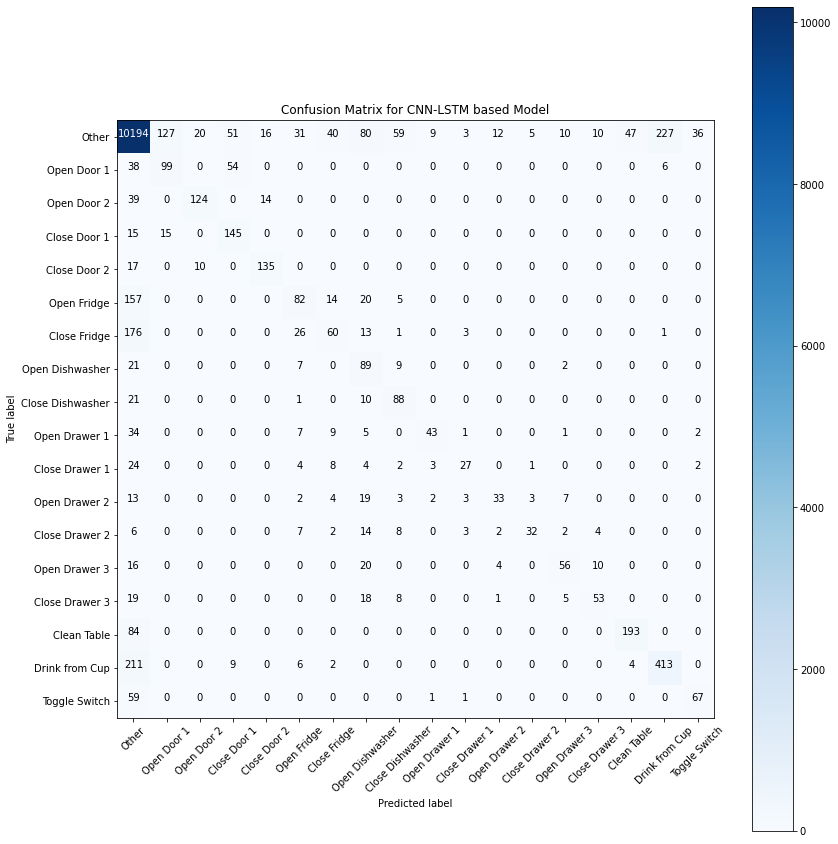

In [218]:
# CNN-LSTM Based Network
predictedY = model_cnn_lstm.predict(testX)
cm_plot_labels = opp.labels
plot_cm(predictedY, testy=opp.testy, classes=cm_plot_labels, title='Confusion Matrix for CNN-LSTM based Model', figureSize=[12, 12])

## Overall accuracy using Weighted F-Beta

In [219]:
predictedY = model_cnn_lstm.predict(testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(opp.testy, axis=1)

precision,recall,fscore, _ = score(y_true,y_pred,average='weighted')
print("CNN-LSTM Based Model:\n")
print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F-score   : {}'.format(fscore))

CNN-LSTM Based Model:

Precision : 0.8469899884412284
Recall    : 0.8463120567375887
F-score   : 0.8427409806066983


# Inception-GRU based Model

## Model Training

In [220]:
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import MaxPooling1D, Conv1D, Flatten, Dense, Concatenate, GRU, Input, InputLayer
from keras.utils.vis_utils import plot_model

In [221]:
class Incept1D(keras.Model):
    def __init__(self, c1, c2, c3, c4):
        super(Incept1D, self).__init__()
        self.p1_1x1_conv = Conv1D(filters=c1, kernel_size=1, activation='relu', padding='same')

        self.p2_1x1_conv = Conv1D(filters=c2[0], kernel_size=1, activation='relu', padding='same')
        self.p2_1x3_conv = Conv1D(filters=c2[1], kernel_size=3, activation='relu', padding='same')

        self.p3_1x1_conv = Conv1D(filters=c3[0], kernel_size=1, activation='relu', padding='same')
        self.p3_1x5_conv = Conv1D(filters=c3[1], kernel_size=3, activation='relu', padding='same')

        self.p4_1x3_maxpool = MaxPooling1D(pool_size=3, strides=1, padding='same')
        self.p4_1x1_conv = Conv1D(filters=c4, kernel_size=1, padding='same', activation='relu')


    def call(self, x):
        p1 = self.p1_1x1_conv(x)
        p2 = self.p2_1x3_conv(self.p2_1x1_conv(x))
        p3 = self.p3_1x5_conv(self.p3_1x1_conv(x))
        p4 = self.p4_1x1_conv(self.p4_1x3_maxpool(x))
        # Concatenate the outputs on the channel dimension
        return Concatenate()([p1, p2, p3, p4])

In [233]:
def get_model(trainX, trainy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    # Model Definitions
    model = Sequential()
    # Input Layer
    model.add(InputLayer(input_shape=(n_timesteps, n_features)))
    model.add(Incept1D(128, (64, 100), (48, 96), 100))
    model.add(Incept1D(156, (96, 113), (64, 84), 72))
    model.add(Incept1D(64, (96, 148), (48, 64), 64))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Incept1D(64, (32, 64), (36, 72), 48))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(GRU(120, return_sequences=True))
    model.add(GRU(40))
    model.add(Dense(n_outputs, activation='softmax',
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                    bias_regularizer=regularizers.l2(1e-4), 
                    activity_regularizer=regularizers.l2(1e-5)
                    ))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print stuff
    print(model.summary())
    return model

In [234]:
model_inception = get_model(opp.trainX, opp.trainy)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
incept1d_20 (Incept1D)       (None, 24, 424)           71980     
_________________________________________________________________
incept1d_21 (Incept1D)       (None, 24, 425)           213769    
_________________________________________________________________
incept1d_22 (Incept1D)       (None, 24, 340)           167924    
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 12, 340)           0         
_________________________________________________________________
incept1d_23 (Incept1D)       (None, 12, 248)           75436     
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 6, 248)            0         
_________________________________________________________________
gru_10 (GRU)                 (None, 6, 120)          

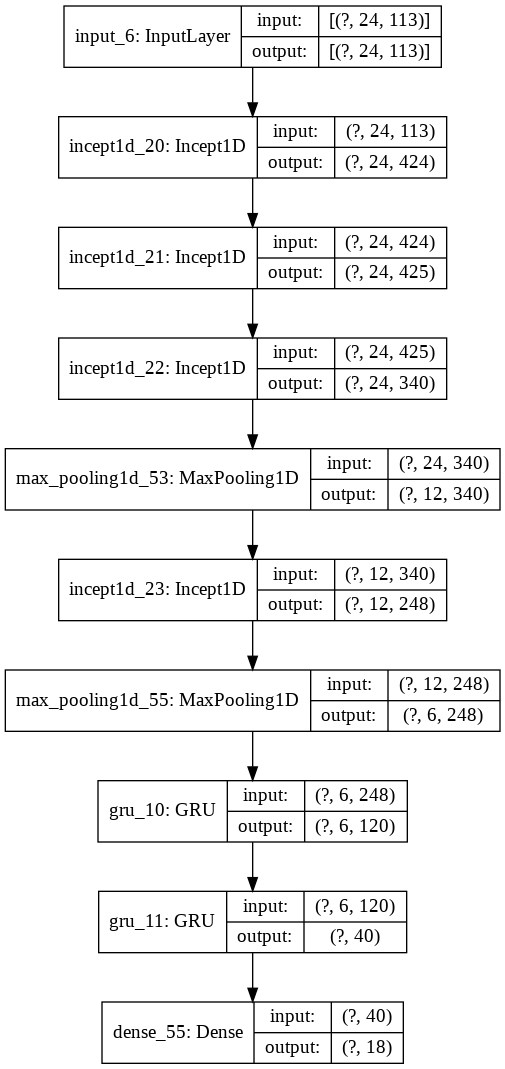

In [235]:
plot_model(model_inception, show_shapes=True, show_layer_names=True)

In [236]:
history_inception = model_inception.fit(x=opp.trainX, y=opp.trainy, validation_data=(opp.testX, opp.testy), verbose=1, batch_size=100, epochs=80)

Epoch 1/80
584/584 [==============================] - 10s 18ms/step - loss: 1.3346 - accuracy: 0.7085 - val_loss: 0.9901 - val_accuracy: 0.7785
Epoch 2/80
584/584 [==============================] - 9s 16ms/step - loss: 0.8954 - accuracy: 0.7483 - val_loss: 0.7186 - val_accuracy: 0.7987
Epoch 3/80
584/584 [==============================] - 9s 16ms/step - loss: 0.6996 - accuracy: 0.7826 - val_loss: 0.6639 - val_accuracy: 0.7926
Epoch 4/80
584/584 [==============================] - 9s 16ms/step - loss: 0.5927 - accuracy: 0.8045 - val_loss: 0.6454 - val_accuracy: 0.7810
Epoch 5/80
584/584 [==============================] - 9s 16ms/step - loss: 0.5262 - accuracy: 0.8209 - val_loss: 0.6181 - val_accuracy: 0.8035
Epoch 6/80
584/584 [==============================] - 9s 16ms/step - loss: 0.4800 - accuracy: 0.8353 - val_loss: 0.5561 - val_accuracy: 0.8298
Epoch 7/80
584/584 [==============================] - 9s 16ms/step - loss: 0.4348 - accuracy: 0.8503 - val_loss: 0.6050 - val_accuracy: 0.815

In [ ]:
# Saving the model
import tensorflow as tf    
tf.keras.models.save_model(
    model_inception,
    "Inception_GRU_OPPORTUNITY.model",
    overwrite=True,
    include_optimizer=True
) 

In [240]:
_, accuracy = model_inception.evaluate(opp.testX, opp.testy, batch_size=64, verbose=1)
print("Accuracy for Inception and GRU based model = {}%".format(accuracy))

221/221 [==============================] - 1s 6ms/step - loss: 0.8572 - accuracy: 0.8106
Accuracy for Inception and GRU based model = 0.8105673789978027%


## Plotting Accuracy

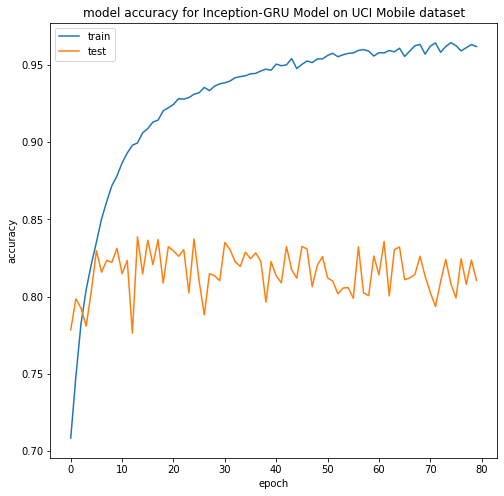

In [241]:
plot_model_accuracy("Inception-GRU Model on UCI Mobile dataset", history=history_inception)

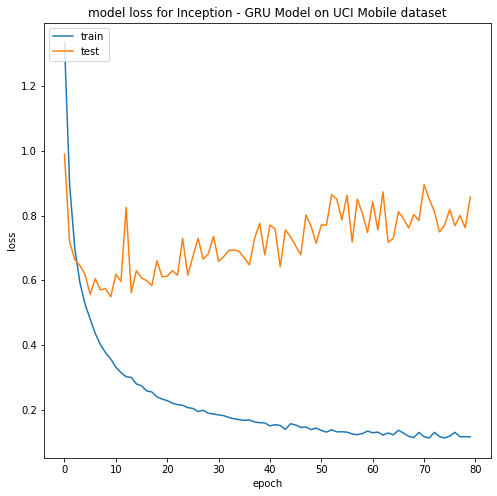

In [242]:
plot_model_loss("Inception - GRU Model on UCI Mobile dataset", history=history_inception)

## Plotting Confusion Matrix

Confusion matrix, without normalization


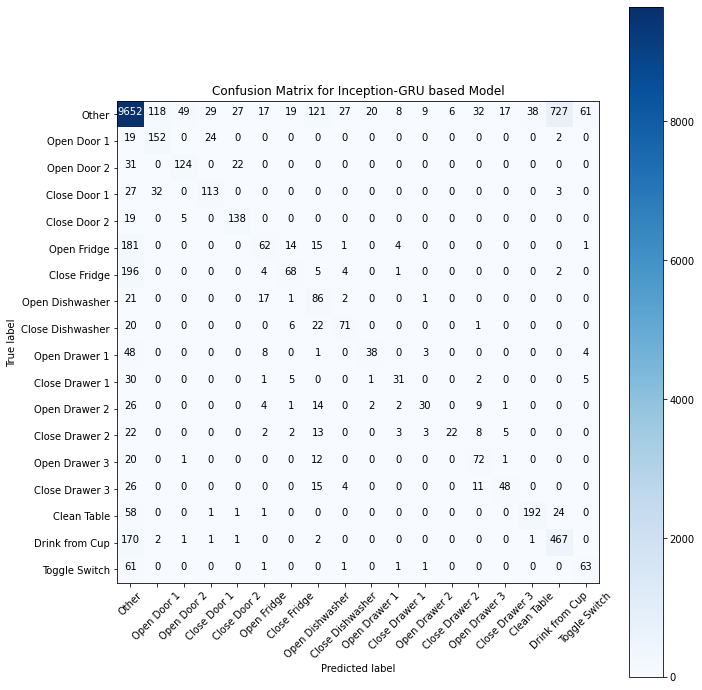

In [246]:
# Inception- GRU based network
predictedY = model_inception.predict(opp.testX)
cm_plot_labels = opp.labels
plot_cm(predictedY, testy=opp.testy, classes=cm_plot_labels, title='Confusion Matrix for Inception-GRU based Model')

## Classification Report

In [247]:
# 1D CNN based Model
predictedY = model_inception.predict(opp.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(opp.testy, axis=1)
target_names = opp.labels
print("Incepion-GRU based Model: \n")
print(classification_report(y_true, y_pred, target_names=target_names))

Incepion-GRU based Model: 

                  precision    recall  f1-score   support

           Other       0.91      0.88      0.89     10977
     Open Door 1       0.50      0.77      0.61       197
     Open Door 2       0.69      0.70      0.69       177
    Close Door 1       0.67      0.65      0.66       175
    Close Door 2       0.73      0.85      0.79       162
     Open Fridge       0.53      0.22      0.31       278
    Close Fridge       0.59      0.24      0.34       280
 Open Dishwasher       0.28      0.67      0.40       128
Close Dishwasher       0.65      0.59      0.62       120
   Open Drawer 1       0.62      0.37      0.47       102
  Close Drawer 1       0.62      0.41      0.50        75
   Open Drawer 2       0.64      0.34      0.44        89
  Close Drawer 2       0.79      0.28      0.41        80
   Open Drawer 3       0.53      0.68      0.60       106
  Close Drawer 3       0.67      0.46      0.55       104
     Clean Table       0.83      0.69      

## Overall accuracy using Weighted F-Beta Score

In [248]:
predictedY = model_inception.predict(opp.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(opp.testy, axis=1)

precision,recall,fscore, _ = score(y_true,y_pred,average='weighted')
print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F-score   : {}'.format(fscore))


Precision : 0.8328421504144208
Recall    : 0.8105673758865248
F-score   : 0.8135871999513021
